# Runtime Test

This notebook contains an empirical evaluation of the runtimes of all testing routines as an addition to the theoretical analysis in the thesis.

In [9]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from descriptor_utils import DescriptorWrapper
from experiment_utils import plot_evaluation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dataset = "proteins"
file_name = f'{dataset}_runtime_data'

In [11]:
descriptors = [
    ['evrap', 'samp', 'sirm', 'scomp'], ['pfh'], ['sector_model'], ['combined_model'], ['shell_model'],
    ['evrap'], ['samp'], ['sirm'], ['scomp'], ['samp_3d'], ['sirm_3d'], ['scomp_3d']
]
data_size = range(200, 1501, 100)

def load_or_compute_runtime(file):
    if os.path.isfile(f'test_output/{file}_runtime_data.csv'):
        df = pd.read_csv(f'test_output/{file}_runtime_data.csv', index_col=0)
        return df.to_dict(orient='list')
    else:
        if not file == 'mc_gill_whole':
            with open(f"point_clouds/{file}.pkl", "rb") as f:
                data = pickle.load(f)
        else:
            data = np.load(f"point_clouds/{file}.npz", allow_pickle=True)
        point_clouds = data['objects']
    
        # duplicate 3 times
        for i in range(3):
            if type(point_clouds) == list:
                duplicate = point_clouds[:]
                point_clouds.extend(duplicate)
            else:
                point_clouds = np.concatenate((point_clouds, point_clouds))
    
        experiment_data = {**{'_'.join(descriptor): [] for descriptor in descriptors}}
        descriptor_wrapper = DescriptorWrapper()
    
        for test_size in tqdm(data_size, desc=""):
            test_data = point_clouds[:test_size]
            for descriptor in descriptors:
                if len(descriptor) < 2:
                    descriptor = descriptor[0]
                    start_time = time.perf_counter()
                    descriptor_wrapper.compute_model_on_dataset(test_data, descriptor)
                    experiment_data[descriptor].append(time.perf_counter() - start_time)
    
            experiment_data['evrap_samp_sirm_scomp'].append(sum(experiment_data[key][-1] for key in ['evrap', 'sirm', 'scomp', 'samp']))
    
        df = pd.DataFrame(experiment_data)
        df.to_csv(f'test_output/{file}_runtime_data.csv', index=False)
        
        return df.to_dict(orient='list')

In [12]:
runtime_data = load_or_compute_runtime(dataset)

100%|██████████| 14/14 [2:11:59<00:00, 565.69s/it]


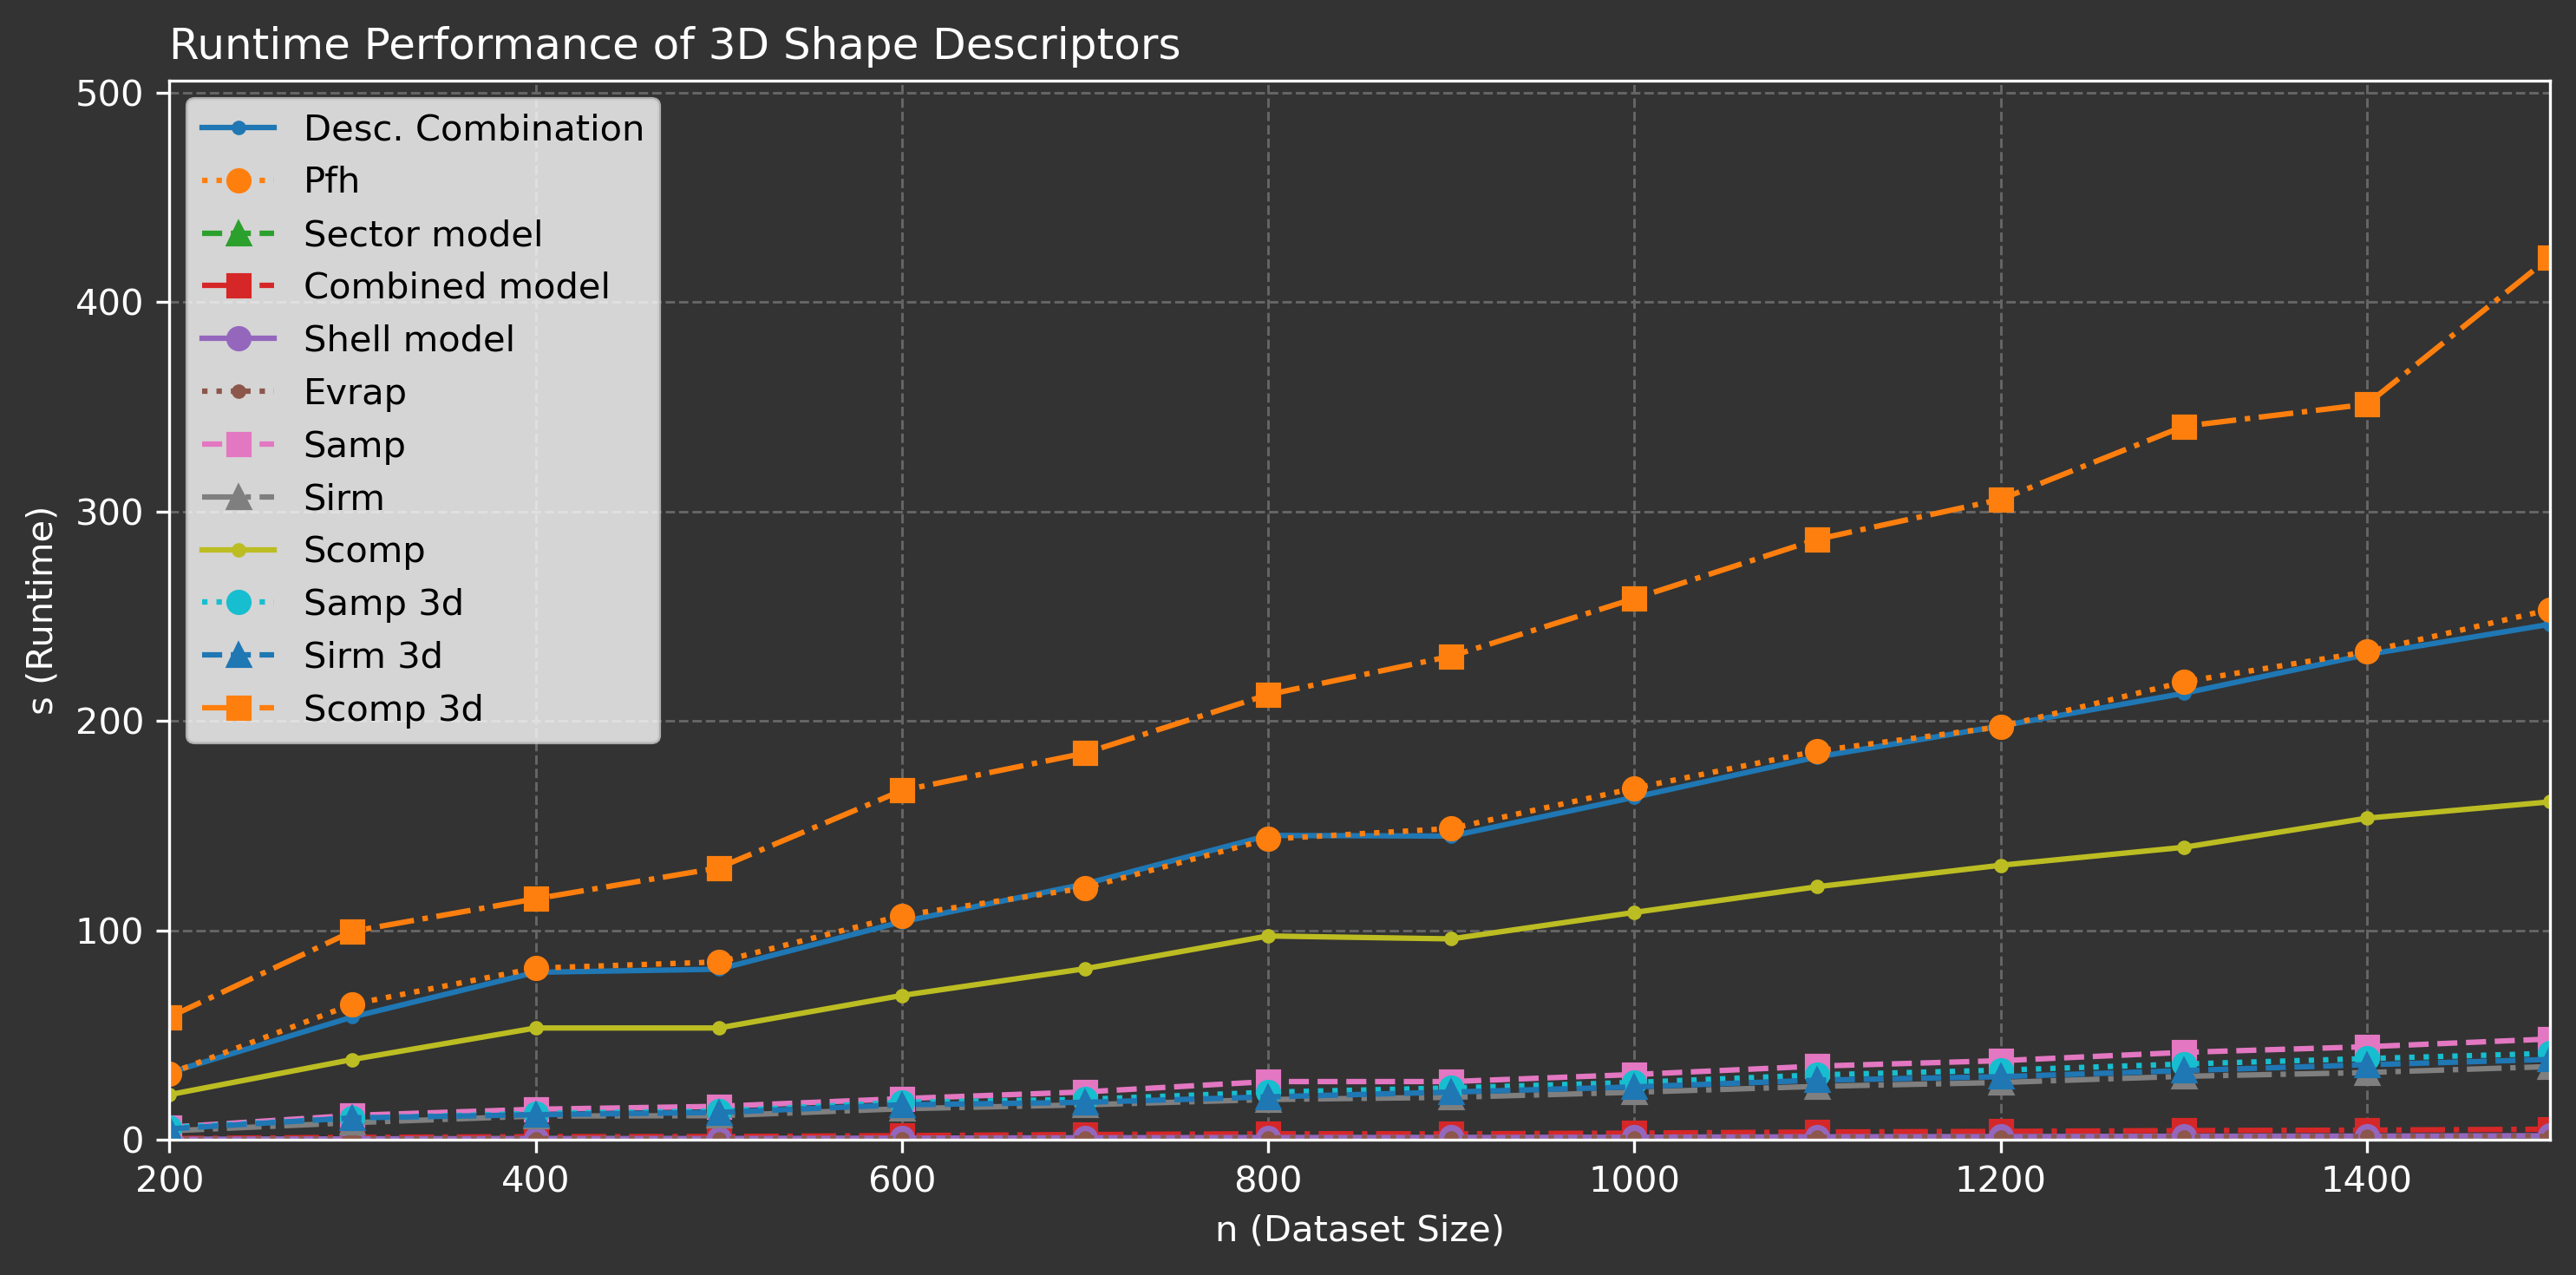

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), dpi=300)  # Example with a 2x2 grid of subplots

plot_evaluation(axes, descriptors, runtime_data, data_size,
                x_label='n (Dataset Size)', y_label='s (Runtime)',
                title='Runtime Performance of 3D Shape Descriptors')

# Set figure background and adjust layout
fig.patch.set_facecolor('#333333')  # Dark grey background for the figure
fig.tight_layout()  # Ensure subplots fit within the figure

plt.savefig(f"figures/{dataset}/runtime/runtime.png", dpi=300)
plt.show()

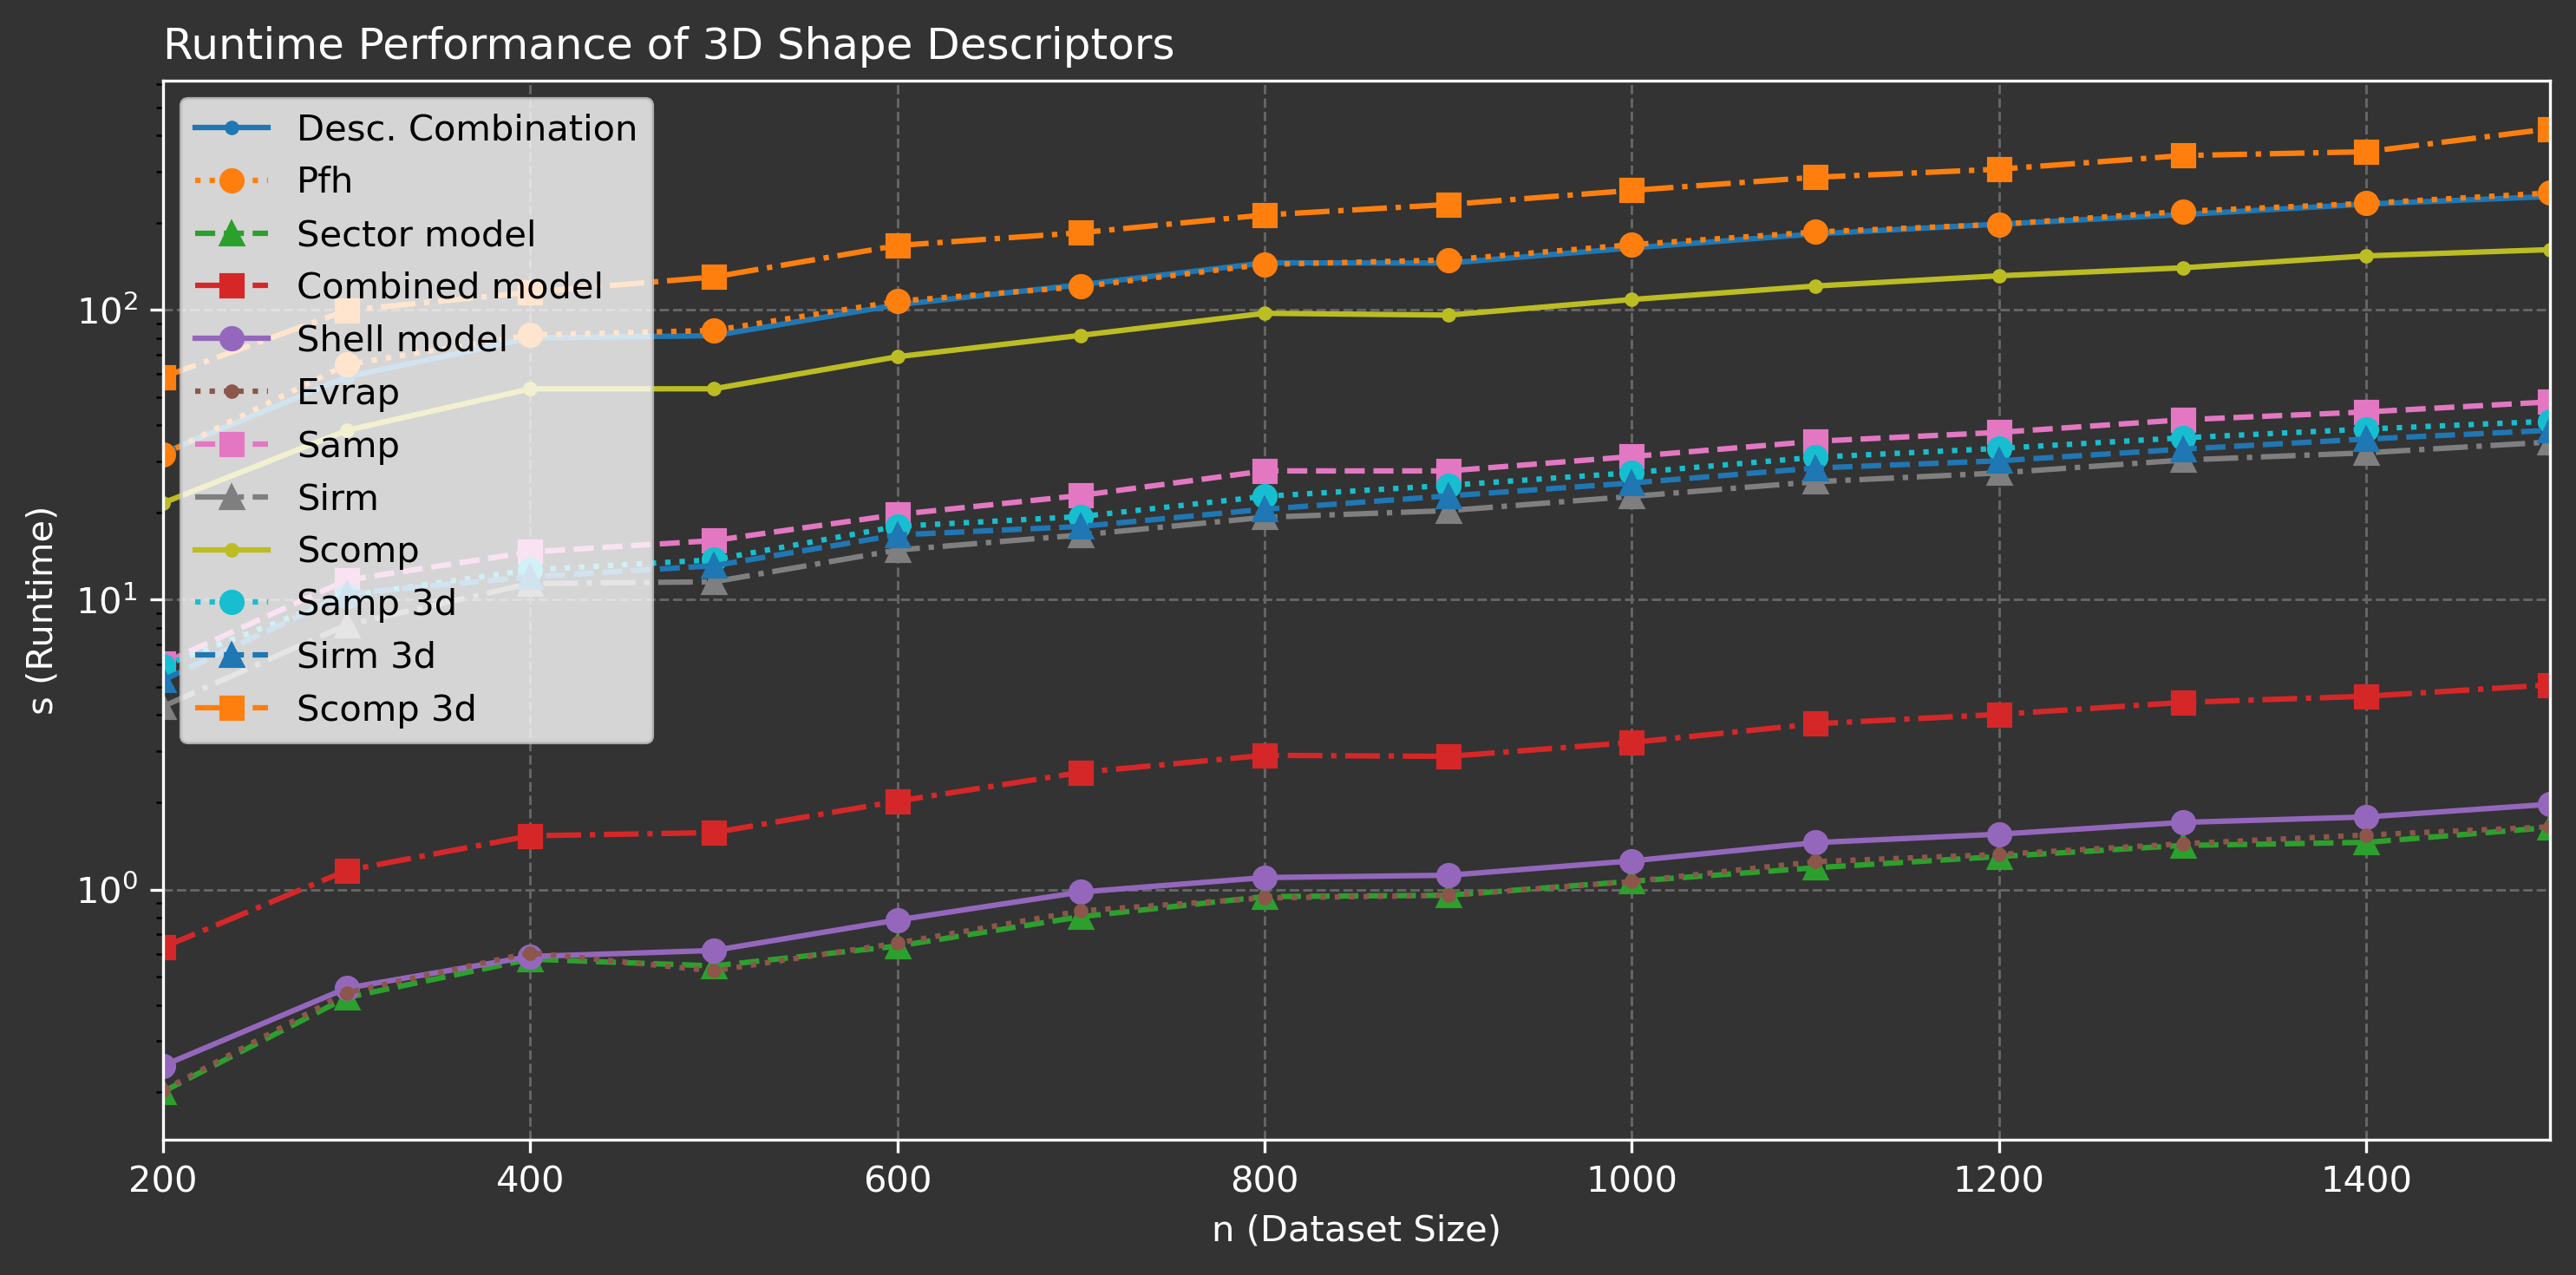

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), dpi=300)  # Example with a 2x2 grid of subplots

plot_evaluation(axes, descriptors, runtime_data, data_size,
                x_label='n (Dataset Size)', y_label='s (Runtime)',
                title='Runtime Performance of 3D Shape Descriptors', log_y=True)

# Set figure background and adjust layout
fig.patch.set_facecolor('#333333')  # Dark grey background for the figure
fig.tight_layout()  # Ensure subplots fit within the figure

plt.savefig(f"figures/{dataset}/runtime/runtime_logy.png", dpi=300)
plt.show()